# COGS 108 - Final Project 

# Overview

In my final project, I try to find out whether there exists a correlated relationship among yelp ratings and number of violations and health inspection scores. Specifically, I wonder whether restaurants which violate critical health standards and have lower health scores would have lower yelp ratings than those which don't. However, there seems to be no correlation among yelp ratings, number of violations and health scores according to my analysis. Hence, we could not tell the health scores of restaurants and number of violations from their yelp ratings.

# Name & PID

- Name: Lechuan Wang
- PID: A15474354

# Research Question

Do restaurants which do not violate the health inspection standards and have higher health scores have higher yelp ratings than those which violate the health inspection standards?

## Background and Prior Work

Local public health departments regularly inspect businesses serving food to ensure restaurants and other food retail outlets are following safe food handling procedure.(1) It focuses on food contamination, temperature control, hygiene, general cleanliness, and healthy aspects.(4) One inspection may not be representative of the overall, long-term sanitation of an establishment, because a restaurant may have greater or fewer violations than observed during an inspection. In addition, some violations noted on an inspection report may have been corrected at the time of the inspection, which are indicated on the report. Follow-up inspections may be conducted for specific critical violations that cannot be corrected at the time of the inspection.(2)

For the grading specification, each restaurant is assigned a letter grade that corresponds to its health inspection score — 90 to 100 points for an A, 80 to 89 for a B and 70 to 79 for a C.(3) These inspection scores will influence the revenue of local restaurants. According to a 2018 study, posting health scores prominently on a business page leads to a 12 percent decrease in purchase intentions for restaurants with poor scores (relative to those with higher scores).(5)

References (include links):
- 1) https://www.foodsafetynews.com/restaurant-inspections-in-your-area/
- 2) https://www.dininggrades.com/blog/challenges-of-health-department-food-safety-inspections/
- 3) https://www.washingtonpost.com/news/voraciously/wp/2018/07/24/yelp-adds-health-inspection-scores-for-restaurants-and-restaurateurs-are-not-happy/
- 4) https://blog.typsy.com/how-do-health-inspections-work#:~:text=Health%20inspectors%20will%20spend%20a,about%20your%20temperature%20measuring%20devices.
- 5) https://www.reviewtrackers.com/blog/yelp-health-score/#:~:text=Yelp%20Health%20Score%20and%20the%20LIVES%20Program&text=The%20data%20can%20be%20seen,100)%20on%20restaurant%20review%20pages.&text=If%20a%20local%20health%20department,inspection%20results%20of%20a%20business.

# Hypothesis


There is a relationship among yelp ratings, health scores and the number of violations of health standards. The rating score might be lower if the restaurant violates the health requirement and has a lower health scores . In addition, the number of critical violations might further decrease the rating scores.

# Dataset(s)

- Dataset Name: inspections.csv
- Link to the dataset: given
- Number of observations: 18466 
<br> The inspections dataset includes information about date, zipcodes, restaurants information, inspection history, number of critical/non-critical violations and scores for each restaurant.
 
 
- Dataset Name: restaurants.csv
- Link to the dataset: given
- Number of observations: 3324
<br> The restaurants dataset includes information about names, location, and zipcodes.

- Dataset Name: yelp.csv
- Link to the dataset: given
- Number of observations: 3688
<br> The yelp dataset includes information about names, ratings, locations, review counts and several severd food.

First, I will combine restaurants and inspections to get the number of violations for each restaurant. Then, I add yelp data set to find the score. Lastly, I will use them to explore my data.

# Setup

In [63]:
## YOUR CODE HERE

%matplotlib inline

# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('talk')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

inspection = pd.read_csv("inspections.csv")
yelp = pd.read_csv("yelp.csv")
restaurants = pd.read_csv("restaurants.csv")

# Data Cleaning

First, I only consider restaurants and inspections. I only need name, address and id to distinguish restaurants. Info related to number of critical/non-critical violations and scores in inspections are needed. Address is also needed to merge with yelp data set later.

In [49]:
# select columns i need from both data sets
df_restaurant = restaurants[['hsisid','name','address1']]
df_inspection = inspection[['hsisid', 'inspection_num', 'num_critical', 'num_non_critical', 'score','address1']]
# Merge data frames
restaurant_inspection = pd.merge(left=df_restaurant, right=df_inspection, on=['hsisid'], how='inner')
# only keep the last inspection result to keep track of the most recent data  
restaurant_inspection = restaurant_inspection.drop_duplicates(subset='hsisid', keep="last")
restaurant_inspection

,hsisid,name,address1_x,inspection_num,num_critical,num_non_critical,score,address1_y
0,4092017230,SPRING CAFE 2,2900-104 SPRING FOREST RD,1,9,7,88.0,2900-104 SPRING FOREST RD
10,4092014444,Taco Bell #22798,2207 S MAIN ST,10,0,3,98.0,2207 S MAIN ST
18,4092015333,THE REMEDY DINER,137 E HARGETT ST,8,11,11,88.5,137 E HARGETT ST
28,4092160069,ZEBULON HOUSE (KITCHEN),551 PONY RD,10,4,3,95.5,551 PONY RD
38,4092110477,CHARLES BUGG CAFETERIA,825 COOPER ST,10,1,3,98.0,825 COOPER ST
...,...,...,...,...,...,...,...,...
18453,4092015461,Zoes Kitchen,1028 OBERLIN RD,7,1,3,98.5,1028 OBERLIN RD
18457,4092016658,LA ROMA PIZZA,1322 FIFTH AVE,4,5,9,92.0,1322 FIFTH AVE
18463,4092016663,BOJANGLES #5,3301 S WILMINGTON ST,6,3,3,97.0,3301 S WILMINGTON ST
18464,4092017227,QUICKLY,4141 DAVIS DR,1,7,14,90.0,4141 DAVIS DR


Then, I change the name of address1_x to address to make sure merging is working in the future.

In [50]:
# rename and standardize addresses
df = restaurant_inspection.rename(columns={"address1_x": "address"})
df['address'] = df['address'].str.lower()
df

,hsisid,name,address,inspection_num,num_critical,num_non_critical,score,address1_y
0,4092017230,SPRING CAFE 2,2900-104 spring forest rd,1,9,7,88.0,2900-104 SPRING FOREST RD
10,4092014444,Taco Bell #22798,2207 s main st,10,0,3,98.0,2207 S MAIN ST
18,4092015333,THE REMEDY DINER,137 e hargett st,8,11,11,88.5,137 E HARGETT ST
28,4092160069,ZEBULON HOUSE (KITCHEN),551 pony rd,10,4,3,95.5,551 PONY RD
38,4092110477,CHARLES BUGG CAFETERIA,825 cooper st,10,1,3,98.0,825 COOPER ST
...,...,...,...,...,...,...,...,...
18453,4092015461,Zoes Kitchen,1028 oberlin rd,7,1,3,98.5,1028 OBERLIN RD
18457,4092016658,LA ROMA PIZZA,1322 fifth ave,4,5,9,92.0,1322 FIFTH AVE
18463,4092016663,BOJANGLES #5,3301 s wilmington st,6,3,3,97.0,3301 S WILMINGTON ST
18464,4092017227,QUICKLY,4141 davis dr,1,7,14,90.0,4141 DAVIS DR


Next step, I add ratings and review counts into the df and keep data with at least 3 times appearance to avoid randomness. Before adding, I need to remove observations without address because address information is necessary to merge datasets. Again, I change "address1" to address like above to allow merging.

In [51]:
yelp = yelp[yelp["review_count"] >= 3]
# remove data if no address available
yelp = yelp.dropna(subset=['address1'])
# select only useful data
df_yelp = yelp[['rating','review_count','name','address1']]
df_yelp = df_yelp.rename(columns={"address1": "address"})
df_yelp['address'] = df_yelp['address'].str.lower()
df_yelp

,rating,review_count,name,address
0,2.5,23,42nd street oyster bar - rdu airport,2400 john brantley blvd
1,4.0,17,aldi foods,2303 nw maynard rd
3,3.0,16,olive garden italian restaurant,3401 raleigh rd pkwy w
4,3.5,3,subway,4934 raleigh rd
5,5.0,5,trent restaurant,129 main st
...,...,...,...,...
3683,3.5,23,carter-finley stadium,4600 trinity rd
3684,3.5,24,raleigh little theatre,301 pogue st
3685,4.0,12,"sky zone trampoline park, durham",1720 guess rd
3686,3.5,4,highgrove estate,1613 s main st


Last step, I merge df and df yelp with respect to name of the restaurant and select columns associated with number of critial violation, ratings, scores and so on. Again, I remove repetative observations by looking at name_x.

In [52]:
df = pd.merge(left=df_yelp, right=df, on=['address'], how='inner')
final = df[['name_x', 'rating', 'num_critical', 'num_non_critical', 'score']]
# same procedure, leave the latest observation
final = final.drop_duplicates(subset='name_x', keep="last")
final

,name_x,rating,num_critical,num_non_critical,score
1,southern women's show,4.0,1,2,97.0
5,raleigh flea market,4.0,1,2,97.0
7,nc state fair,4.0,1,2,97.0
8,kome asian cuisine,3.5,1,5,95.0
9,remington grill,3.0,1,5,95.0
...,...,...,...,...,...
289,scooters grill & bar,3.5,0,3,99.0
290,olive garden italian restaurant,3.0,0,10,96.5
291,springhill suites raleigh cary,4.0,1,1,98.5
292,t.mac,2.5,7,9,92.0


# Data Visualization & Analysis

First, we draw a counter plot and look at the distribution of overall ratings.

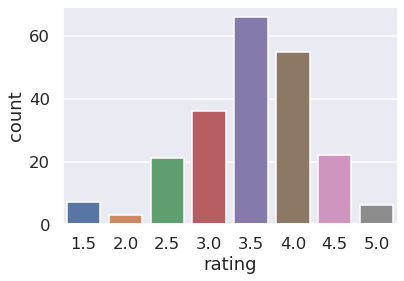

In [53]:
sns.countplot(x="rating", data=final)

f1 = plt.gcf()

The plot shows that the rating is close to a normally distributed graph.

I care about how many different score are in the dataset and what is the difference between max and min.

In [54]:
n_scoring = len(final['score'].unique())
n_scoring

25

In [55]:
final['score'].max() - final['score'].min()

15.5

I want to use median to separate the data into two parts. The score higher than median is considered as good score. Then, I calculate the avg rating for each part.

In [56]:
mid = final['score'].median()

In [57]:
r_h = final[final['score'] >= mid]['rating'].values
r_nh = final[final['score'] < mid]['rating'].values
avg_r_h = r_h.mean()
avg_r_nh = r_nh.mean()
print('Average rating of restaurants have good health grade is \t {:2.2f}'.format(avg_r_h))
print('Average rating of restaurants do not have good health grade \t\t {:2.2f}'.format(avg_r_nh))

Average rating of restaurants have good health grade is 	 3.55
Average rating of restaurants do not have good health grade 		 3.45


It seems like there is a small difference in rating between good health grade and not good health grade. I want to test the normality distributions and see the distribution of both groups. My assumption is that good health grade would have higher averge rating. 

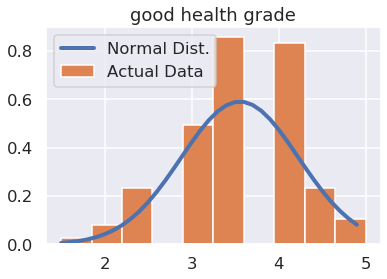

In [58]:
xs = np.arange(r_h.min(), r_h.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(r_h), np.std(r_h))
plt.plot(xs, fit, label = 'Normal Dist.', lw = 4)
plt.hist(r_h, density = True, label = 'Actual Data');
plt.title('good health grade')
plt.legend();

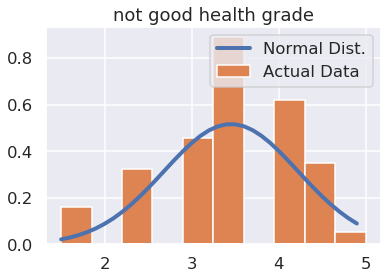

In [59]:
xs = np.arange(r_nh.min(), r_nh.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(r_nh), np.std(r_nh))
plt.plot(xs, fit, label = 'Normal Dist.', lw = 4)
plt.hist(r_nh, density = True, label = 'Actual Data');
plt.title('not good health grade')
plt.legend();

In [60]:
t_val, p_val = ttest_ind(r_h, r_nh)
if p_val < 0.01:
    print('There is a significant difference!')
else:
    print('There is NOT a significant difference!')

There is NOT a significant difference!


It seems like the distribution of these two kinds is pretty similar. If my assumption is correct, good health grade should have a tendency to have more 4-5 ratings. However, that is not the case here. Hence, I can not draw conclusion that the good health grade correlates with higher rating.

In [61]:
outcome_1, predictors_1 = patsy.dmatrices('rating ~ num_critical+num_non_critical+score', final)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.7268
Date:                Fri, 12 Jun 2020   Prob (F-statistic):              0.537
Time:                        20:56:48   Log-Likelihood:                -236.36
No. Observations:                 216   AIC:                             480.7
Df Residuals:                     212   BIC:                             494.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2601      2.606  

Based on the model I ran above (using alpha value of 0.01), none of these variables seem to be statistically significant. In addition, the coefficients for three variables are very small. So they may not affect the rating of the restaurant. In the end, I could not make the conclusion that there is correlation among yelp ratings and number of violations and health inspection scores.
Therefore, I could not support my hypothesis. Thus, the number of violations and health scores do not have effects on the yelp rating of the restaurant.

# Ethics & Privacy

When we use yelp data from yelp website, we need to ask users for permission. Otherwise, we can not use their data in this research. For restaurant data set, I do not include private information such as name, address and geolocation information. Also, since this data set contains information about local restaurants, we need to ask local restaurants and governments for permission to continue my research. Since I do not include restaurants names in the final report, there will be less impacts such as loss of customers or increasing inspection frequency in a certain restaurant.

The inspection dataset is available on local government websites and to all people. So there is no obvious privacy issue for this dataset. However, I should be careful about customers' private information and should not abuse these info.

The data is collected randomly from local restaurants, so there should be little bias in this dataset. However, since the data is only from local restaurants, I could only make conclusions in this certain area.

# Conclusion & Discussion

In my project, I try to discover the relationship among restaurants yelp ratings, health scores and number of critical/non-critical violations of health inspections in North Carolina. I use restaurants, yelp review and inspections dataset which are all provided by the professor. These three data sets include information about local restaurants yelp rating, health scores, number of violations, severity, type of violations, and etc. If there's is a correlation, people could dine in clean restaurants and keep healthy by looking at the yelp rating.

I tried to build a linear model using three variables and use t test to reject null hypothesis about the distribution of rating. However, both methods did not work here. The linear model found that none of three variables are statistically significant. Based on the model I ran above (using alpha value of 0.01), all variables have p value > 0.01 and very small coefficient at the same time. In the end, I could not make the conclusion that there is correlation among yelp ratings and number of violations and health inspection scores.

Since the data is only collected in North Carolina, I could only make conclusions in this area. Also, some of the variables in data sets are hard to interpret, so I choose to use variables that are easier to deal with. My project could help people to have access to healthy food by checking yelp scores and restaurants themselves will tend to keep their food fresh and clean to improve yelp rating and attract more customers.